In [1]:
### Libraries ###
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import interp1d
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

4. Write a Monte Carlo simulation that generates scattering events following the distributions found analytically; 
5. Produce a synthetic dataset of about $N=10^5$ (or more) events. Events should be expressed as rows in a file with columns representing the muons coordinates;
6. Assume a $3$ cm thick Beryllium block is used as a target, and the rate of positrons on the target is $10^6$ Hz. Compute a rescaling factor (weight) you need to apply to each one of the $N$ simulated events such that they represent the statistics that would be gathered in a week of countinuous operations.

In [2]:
## Constants ##

alpha  = 1 / (137.035999084) #  Fine-Structure constant
mu = 105.6583755       # [MeV] Muon mass
me    = 0.51099895        # [MeV] Electron mass
sqr_s      = 250.          # [MeV] Invariant mass  
N =   10**5               # number of muons pair

In [3]:
#Definition of functions

""" Kinematic's formula  """
def b_mu(s):
    return (1 - 4*mu**2/s)**0.5

def b_me(s):
    return (1 - 4*me**2/s)**0.5

def norm(s):
    return (s/4 - mu**2)**0.5

def tan_lab(theta):
    return np.sin(theta) * (1 - b_me(s))**0.5 / (np.cos(theta) + b_me(s)/b_mu(s)) 

def boost_e(s, px):
    return (1 - b_me(s))**0.5 * s + b_me(s) *( 1 - b_me(s))**0.5 * px

def boost_px(s,px):
    return (1 - b_me(s))**0.5 * px + b_me(s) *( 1 - b_me(s))**0.5 * s

""" -----------------------------------------"""

""" Differential cross section formula [MeV^-2 sr^-1] """
def sigma_diff (s,theta):
    return alpha**2/(4*s) * (b_mu(s)/b_me(s)) * (1. + 4.*(me**2 + mu**2)/s + b_me(s)**2 * b_mu(s)**2 * np.cos(theta)**2)

""" Cross section formula [MeV^-2 sr^-1] """
def sigma(s):
    return (4 * alpha**2 * np.pi)/(3 * s**3) * (b_mu(s)/b_me(s)) * (2 * me**2 + s) * (2 * mu**2 + s)

""" Angular distribution formula  """ #Not sure this is the angular distribution formula
def ang(theta):
    return 2 * np.pi * np.sin(theta) * sigma_diff(s,theta) / sigma(s)

# this allows 
def cdf_ang(s,theta):
    return -1/3 * 3/8 * (s**2/((2*me**2+s)*(2*mu**2+s))) * np.cos(theta) * (3 * 4/s * (me**2+mu**2) + b_me(s) * (np.cos(theta))**2 + 3)


# Montecarlo with monochromatic beam

The first simulation of the scattering process is based on a monochromatic positron beam, i.e. it has the following characteristics:
- we assume its transversal section to be point-like;
- all the beam particles have the same energy.

In order to sample $\theta$ distributed according to the differential cross section, we will use the inverse transform method. 
Since we know the analytic form of CDF of the angular distribution in the CoM frame $g(\theta^*)$, this approach can be applied and 
leads to better performances. The distribution $h(\varphi^*)$ is infact uniform in the interval [0,$2\pi$]. Namely we have:

$$
g(\theta^*) = \frac{2\pi \sin(\theta^*)}{\sigma^*} \cdot \frac{\mathrm{d}\sigma^*}{\mathrm{d}\Omega^*} \quad \quad \text{and} \quad \quad h(\varphi^*) = \frac{1}{2\pi}

$$

The CDF is computed through the following: 

\begin{align}
\text{CDF}[ g(\theta^*)]=  \int_0^{\theta^*} g(\theta^*)  \mathrm{d}\theta^*  
= \int_0^{\theta^*} \frac{2\pi \sin(\theta^*)}{\sigma} \cdot \frac{\alpha^2}{4s} \left(1- \frac{4 m_\mu^2}{s}\right)^{1/2} \left(1- \frac{4 m_e^2}{s}\right)^{-1/2}\left[ 1+ \frac{4}{s} (m_e^2 + m_\mu^2) + \left(1-\frac{4 m_e^2}{s}\right)\left(1-\frac{4 m_\mu^2}{s}\right)\cos^2\theta^*\right]  \\ = 
\frac{2\pi}{\sigma} \frac{\alpha^2}{4s} \left(1- \frac{4 m_\mu^2}{s}\right)^{1/2} \left(1- \frac{4 m_e^2}{s}\right)^{-1/2}
    \cdot \left\{\left[1+ \frac{4}{s} (m_e^2 + m_\mu^2)\right] (1 - \cos\theta^*) + \frac{1}{3}\left(1-\frac{4 m_e^2}{s}\right)\left(1-\frac{4 m_\mu^2}{s}\right)(1 - \cos^3\theta^*)\right\} \tag{0.1}
\end{align}

To generate the events:

$a_i$ random uniform in [0,1] $\implies$ CDF[$g(\theta^*)]^{-1}$($a_i$) =$\theta^*_i \\$ 
$b_i$ random uniform in [0,$2\pi$] $\implies$ CDF[$h(\theta^*)]^{-1}$($b_i$) =$\varphi^*_i $

The inverse of the CDF is computed by interpolation through different methods available in the scipy library, i.e. ``UnivariateSpline``, ``InterpolatedUnivariateSpline`` and ``interp1d``.


In [4]:
def g_cdf(s, theta):
    '''CDF for the theta* distribution'''
    
    return (4 * (2 * me**2 + s) * (2 * mu**2 + s) - 3 * s * (4 * me**2 + 4 * mu**2 + s) * np.cos(theta) + (4 * me**2 - s) * (-4 * mu**2 + s) * np.power(np.cos(theta),3)) / \
           (8 * (2 * me**2 + s) * (2 * mu**2 + s))

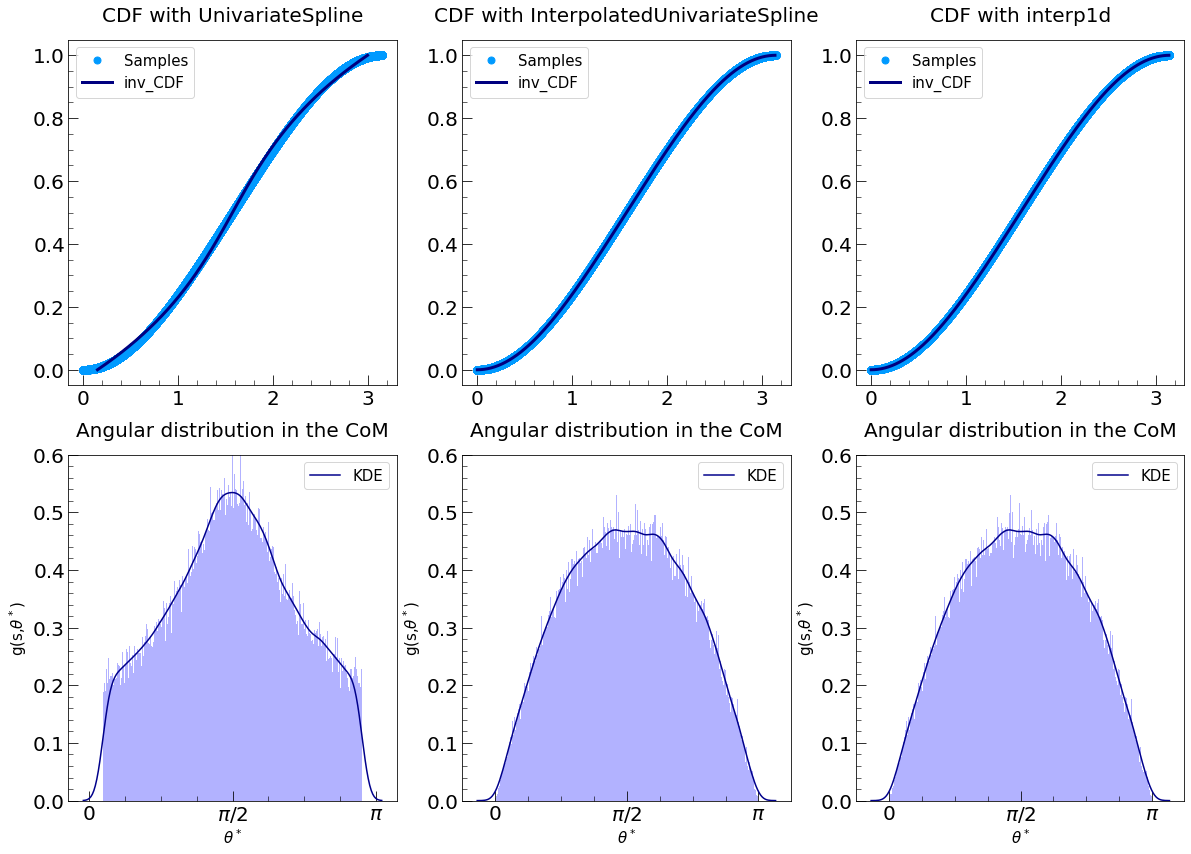

In [5]:
fig, ax = plt.subplots(2,3, figsize = (20,14))

# Angles in the CoM frame on which we sample the inverse CDF
theta_star = np.linspace(0, np.pi, N)

s = sqr_s**2 

# three version of inverse CDF sampling
inv_cdf1 = UnivariateSpline(g_cdf(s,theta_star),theta_star, ext=0)
inv_cdf2 = InterpolatedUnivariateSpline(g_cdf(s,theta_star),theta_star, ext=0)
inv_cdf3 = interp1d(g_cdf(s, theta_star), theta_star, fill_value='extrapolate') #'extrapolate' is needed for the points at z=0,1, which are 'very slightly' outside of the samples
    
# Sample some angles
num_samples = N
unif_samples = np.random.uniform(size=num_samples)
samples_sorted = np.sort(unif_samples)

phis = np.random.uniform(0, 2 * np.pi, size=num_samples)

#same plot on each ax of the points
for i in range(3):
    ax[0][i].plot(theta_star,g_cdf(s,theta_star),'o',markersize= 7,color = '#009AFF',label='Samples')
    ax[1][i].set_title('Angular distribution in the CoM', pad = 18, fontsize=20)
    ax[1][i].set_ylim(0,0.6)
    ax[1][i].set_xticks([0,np.pi/2,np.pi],['0','$\\pi/2$','$\\pi$'] )
    ax[1][i].set_xlabel('$\\theta^*$',fontsize = 15)
    ax[1][i].set_ylabel('g(s,$\\theta^*$)',fontsize = 15)   


### UnivariateSpline ###
ax[0][0].set_title('CDF with UnivariateSpline', pad = 18, fontsize=20)
ax[0][0].plot(inv_cdf1(samples_sorted),samples_sorted,color = 'navy',label = 'inv_CDF',linewidth = 3) 
sns.distplot(inv_cdf1(samples_sorted), ax = ax[1][0],kde = True, kde_kws  = {'label': 'KDE',  'color': 'darkblue'},hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'}, bins = int(np.sqrt(N)))


### InterpolatedUnivariateSpline ###
ax[0][1].set_title('CDF with InterpolatedUnivariateSpline', pad = 18, fontsize=20)
ax[0][1].plot(inv_cdf2(samples_sorted),samples_sorted,color = 'navy',label = 'inv_CDF',linewidth = 3) 
sns.distplot(inv_cdf2(samples_sorted), ax = ax[1][1],kde = True, kde_kws  = {'label': 'KDE',  'color': 'darkblue'},hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'}, bins = int(np.sqrt(N)))

### interp1d ###
ax[0][2].set_title('CDF with interp1d', pad = 18, fontsize=20)
ax[0][2].plot(inv_cdf3(samples_sorted),samples_sorted,color = 'navy',label = 'inv_CDF',linewidth = 3) 
sns.distplot(inv_cdf3(samples_sorted), ax = ax[1][2],kde = True, kde_kws  = {'label': 'KDE',  'color': 'darkblue'},hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'},bins = int(np.sqrt(N)))

for ax in fig.get_axes():
    # plot settings                    
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
    ax.minorticks_on()
    ax.legend(loc='best', fontsize=15)
    
plt.show()


Different interpolating functions lead to different distribution: in particular the ``InterpolatedUnivariateSpline``method is not able to fit the extremes providing a wrong angular distribution. 
We then decide to use the ``interp1d`` method. 

In order to generate the scattering events we definie a routine that is implemented in the function `generate_beam`, which returns the two muons 3-momenta in the laboratory frame. 

In [6]:
def generate_beam(sqr_s, batch_size = 10**5):
    '''Function that generates one batch of scattering events
    
    Parameters:

    sqr_s : float
           Center of mass energy (sqrt(s)) in MeV (must be > 2 mu)
           
    batch_size : int, optional
                 Number of events to generate in one batch
                       
    Returns:

    batch : ndarray of size (batch_size, 6)
            Each row is one event, and contains the components of the 3-momenta (in the laboratory frame)
            of the muon-antimuon pair, in [MeV/c]
    '''
    
    assert sqr_s > 2 * mu, 'There is not enough energy for muon pair production'
    s = sqr_s**2 

    pnorm = norm(s) # Norm of muon 3-momentum in CM
    
    # Compute inverse CDF of g(theta*) by interpolation 
    theta_star = np.linspace(0, np.pi, N)
    inv_cdf = interp1d(g_cdf(s, theta_star), theta_star, fill_value='extrapolate')

    # Sample angles
    num_samples = N
    unif_samples = np.random.uniform(size=batch_size)

    phis = np.random.uniform(0, 2 * np.pi, size=batch_size)
    thetas = inv_cdf(unif_samples)
    
    
    # Compute cartesian components of 3-vector
    px_cm = pnorm * np.cos(thetas)
    py_cm = pnorm * np.sin(thetas) * np.cos(phis)
    pz_cm = pnorm * np.sin(thetas) * np.sin(phis)


    def gamma_e(s):
        return 1 / np.sqrt(1 - b_me(s)**2)
    

    def energy_x_boost(s, x_cm):

        E_cm  = np.sqrt(s) / 2
        gamma = gamma_e(s)
        beta  = b_me(s)
        
        return (gamma * ( E_cm + beta * x_cm ), gamma * (beta * E_cm + x_cm))

    _,px1 = energy_x_boost(s, px_cm)  # px for first muon
    _,px2 = energy_x_boost(s, -px_cm) # px for second muon
    # py and pz are orthogonal to boost axis, and so they remain the same
    
    return np.stack((px1, py_cm, pz_cm, px2, -py_cm, -pz_cm), axis=1)    




In [7]:
# generate events 
events = generate_beam(250, 10**5)
# save events in txt file and dataframe 
np.savetxt("Momenta_monochromatic.txt", events) # save to file
df_monochromatic = pd.DataFrame(events, columns = [  '$px_{\mu_1}$','$py_{\mu_1}$','$pz_{\mu_1}$','$px_{\mu_2}$','$py_{\mu_2}$','$pz_{\mu_2}$'])
df_monochromatic.to_csv('Events.csv')
df_monochromatic

,$px_{\mu_1}$,$py_{\mu_1}$,$pz_{\mu_1}$,$px_{\mu_2}$,$py_{\mu_2}$,$pz_{\mu_2}$
0,41791.220378,-17.194453,45.431919,19362.993107,17.194453,-45.431919
1,45551.687492,-25.979008,6.245402,15602.525993,25.979008,-6.245402
2,16724.944714,34.815846,-6.518303,44429.268771,-34.815846,6.518303
3,46856.555211,5.558886,1.212801,14297.658274,-5.558886,-1.212801
4,24456.738113,54.523848,29.367610,36697.475371,-54.523848,-29.367610
...,...,...,...,...,...,...
99995,40908.290812,40.293214,-32.466464,20245.922673,-40.293214,32.466464
99996,39391.134443,24.422708,-50.661205,21763.079042,-24.422708,50.661205
99997,36372.774987,62.376036,-3.032580,24781.438498,-62.376036,3.032580
99998,43257.992445,42.116806,0.404556,17896.221040,-42.116806,-0.404556


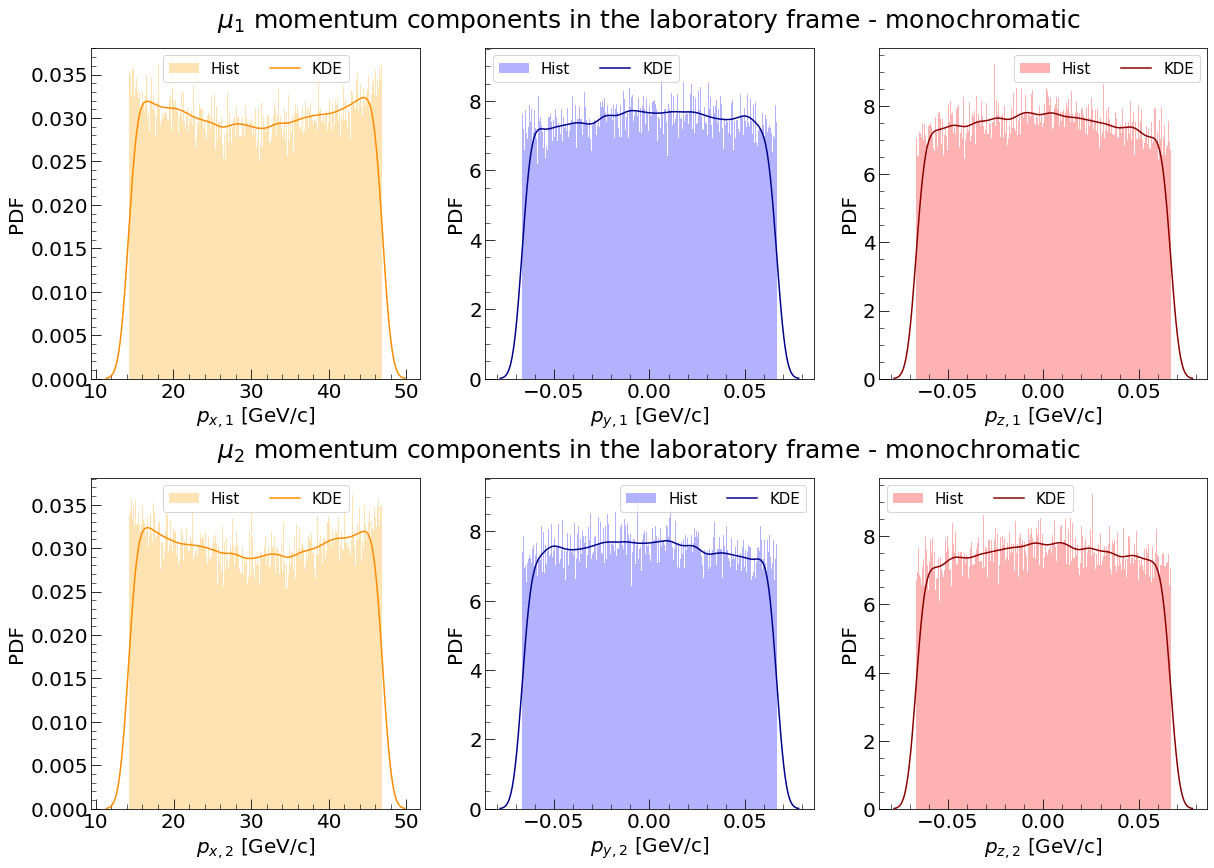

In [8]:
fig, ax = plt.subplots(2,3, figsize = (20,14))

#plotting momentum components distribution in the LAB frame


### MUON 1 ###
# px
sns.distplot(df_monochromatic['$px_{\mu_1}$']/1000,
             ax = ax[0][0],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkorange',   'label': 'KDE'},
             hist_kws = {'color': 'orange', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
             )

            
# py
sns.distplot(df_monochromatic['$py_{\mu_1}$']/1000,
             ax = ax[0][1],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkblue',   'label': 'KDE'},
             hist_kws = {'color': 'blue', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
             )
            
# pz
sns.distplot(df_monochromatic['$pz_{\mu_1}$']/1000,
             ax = ax[0][2],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkred',   'label': 'KDE'},
             hist_kws = {'color': 'red', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
            )


ax[0][0].set_xlabel(r'$p_{x,1}$ [GeV/c]',fontsize = 20)
ax[0][1].set_xlabel(r'$p_{y,1}$ [GeV/c]',fontsize = 20)
ax[0][2].set_xlabel(r'$p_{z,1}$ [GeV/c]',fontsize = 20)

ax[0][1].set_title('$\mu_1$ momentum components in the laboratory frame - monochromatic',fontsize = 25,pad = 20)


### MUON 2 ###
# px
sns.distplot(df_monochromatic['$px_{\mu_2}$']/1000,
             ax = ax[1][0],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkorange',   'label': 'KDE'},
             hist_kws = {'color': 'orange', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
             )
            
# py
sns.distplot(df_monochromatic['$py_{\mu_2}$']/1000,
             ax = ax[1][1],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws = {'color':'darkblue','label':'KDE'},
             hist_kws = {'color': 'blue', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
             )
            
# pz
sns.distplot(df_monochromatic['$pz_{\mu_2}$']/1000,
             ax = ax[1][2],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkred', 'label':'KDE'},
             hist_kws = {'color': 'red', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
            )


ax[1][0].set_xlabel(r'$p_{x,2}$ [GeV/c]',fontsize = 20)
ax[1][1].set_xlabel(r'$p_{y,2}$ [GeV/c]',fontsize = 20)
ax[1][2].set_xlabel(r'$p_{z,2}$ [GeV/c]',fontsize = 20)

ax[1][1].set_title('$\mu_2$ momentum components in the laboratory frame - monochromatic',fontsize = 25, pad = 20)

for ax in fig.get_axes():
    # plot settings   
    ax.set_ylabel('PDF',fontsize = 20)                   
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
    ax.minorticks_on()
    ax.legend(loc='best', fontsize=15, ncol = 2)


plt.subplots_adjust(hspace=.3)
plt.show()



The momentum y and z components show a uniform distribution, centered in zero, as expected. On the other hand the x component distribution presents a negative concavity
with peaks at the extremes of the interval. In order to analyze how this distribution changes according to the inveriant mass, we generate events with 
$\sqrt{s}$ = $2m_{\mu} + \epsilon$, where $\epsilon$ is a quantity that will be varied in a certain range.

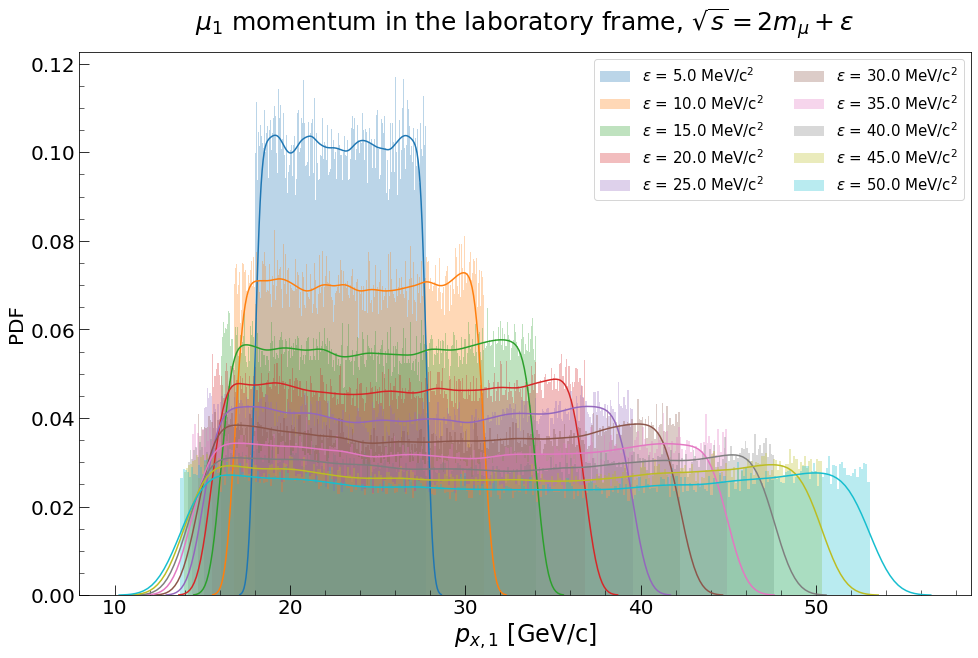

In [19]:
### P_x distribution in function of available energy ###
epsilon = 0.1

for i in range(1,11):
    epsilon = i*5
    sqr_s = 2*mu + epsilon
    events = generate_beam(sqr_s, 10**5)
    globals()[f'df{i}'] = pd.DataFrame(events, columns = [ '$px_{\mu_1}$','$py_{\mu_1}$','$pz_{\mu_1}$','$px_{\mu_2}$','$py_{\mu_2}$','$pz_{\mu_2}$'])


fig, ax = plt.subplots(1,1, figsize = (16,10))

# plotting momentum components distribution in the LAB frame

for i in range(1,11):
    epsilon = 5*i
    sns.distplot(globals()[f'df{i}']['$px_{\mu_1}$']/1000,
                ax = ax,
                bins = int(np.sqrt(N)),
                kde = True,
                #kde_kws  = {'color': 'darkorange',   'label': 'KDE'},
                hist_kws = { 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': '$\epsilon$ = {:.1f} MeV/c$^2$'.format(epsilon)}
                )

ax.set_xlabel(r'$p_{x,1}$ [GeV/c]',fontsize = 24)
ax.set_title('$\mu_1$ momentum in the laboratory frame, $\sqrt{s}=2m_{\mu}+\epsilon$',fontsize = 25,pad = 20)

for ax in fig.get_axes():
    # plot settings   
    ax.set_ylabel('PDF',fontsize = 20)                   
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
    ax.minorticks_on()
    ax.legend(loc='best', fontsize=15, ncol = 2)

plt.show()

# Berilium target 

The number of $\mu^+ \mu^-$ pairs produced per positron bunch on target is given by:
$$n_\mu =  n_+ \rho^- l_t \sigma $$
where $n_+$ is the number of positrons in the bunch, $\rho^-$ is the electron density in the medium, $l_t$ is the thickness of the target, and $\sigma$ is the total cross section for the $e^+ e^- \to \mu^+ \mu^-$ process.
We can then express it as a function of the impinging positrons rate $f_+$, which reads:
$$f_\mu =  f_+ \rho^- l_t \sigma $$

 $\rho^-$ can be computed as:
$$ \rho^- = N_A \frac{\rho_{\mathrm{Be}}}{M_t} Z $$
with $\rho_{\mathrm{Be}}$ being the target's density, $M_t$ its molar mass, and $Z$ its atomic number. [cite LEMMA article]

So, if we generate $N$ events, the correct statistics for an experiment carried out for a time interval $\Delta T$ can be computed by rescaling histograms by a factor $W = f_\mu \Delta T / N$, with $\Delta T$ in seconds.

Muon pairs produced per second:  2.9871179246970954
Muon pairs produced in a week:  1806608.9208568032


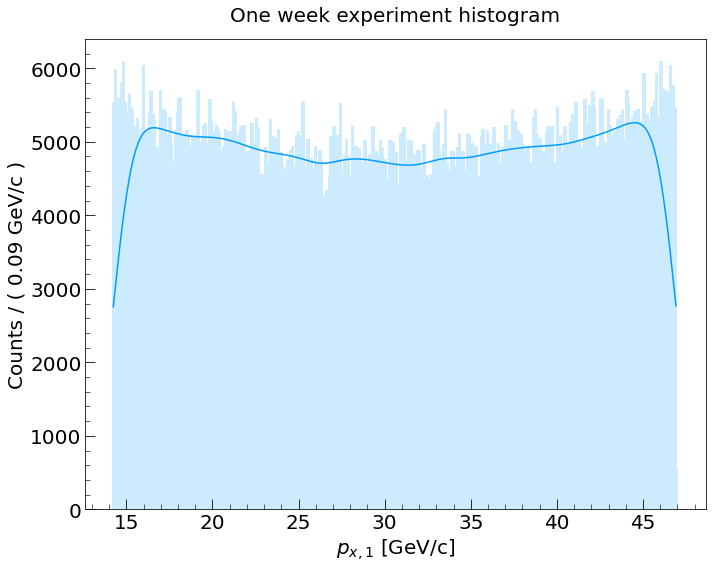

In [17]:

s = 250**2 

cross_sec = sigma(s) * 389.4 * 1e-24 # Total cross section [cm^-2]

freq    = 1e6       # Positrons rate on target [Hz]
rhoBe = 1.848       # Beryllium density     [g/cm^3]
MBe   = 9.012       # Beryllium molar mass  [g/mol]
ZBe   = 4           # Beryllium atomic number
lt    = 6           # Target thickness      [cm]
N_a    = 6.022e23   # Avogadro's number     [mol^-1]


T     = 3600 * 24 * 7   # seconds in a week

rho_electrons = N_a * rhoBe * ZBe / MBe         # Be Electron density [n.e-/cm^3]
fmu    = freq * rho_electrons * lt * cross_sec          # Rate of produced muon pairs [Hz]
N_week = fmu * T                                # Number of muons produced in a week (rescaling factor)


print("Muon pairs produced per second: ", fmu)
print("Muon pairs produced in a week: ", N_week)


weights = np.full(int((N)), N_week/N)                     # array of rescaling factors
df_monochromatic['weights']=weights  


fig, ax = plt.subplots(1, figsize = (10,8))

sns.histplot(x=df_monochromatic['$px_{\mu_1}$']/1000,
             ax=ax,
             stat='count',
             weights= df_monochromatic['weights'], 
             bins = int(np.sqrt(N)), 
             kde=True,
             lw=2,
             edgecolor   = "#ccebff",
             color       = "#009CFF",
             binwidth = 0.09
              )


ax.set_title("One week experiment histogram",fontsize = 20, pad = 18)
ax.set_xlabel(r'$p_{x,1}$ [GeV/c]',fontsize = 20)

# plot settings   
ax.set_ylabel('Counts / ( 0.09 GeV/c )',fontsize = 20)                   
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
ax.minorticks_on()


fig.tight_layout()
plt.show()

8. Given that the electrons traversing the target lose energy ($E(x)=E_0 \exp{-x/X_0}$), with $z$ the longitudinal coordinate of the target, 
the one parallel to the beam direction and $X_0$ is the Beryllium radiation length), compute the
nominal beam energy $E_0$ such that muon pairs can be generated along the whole length of the target. 

The threshold energy for muon production in the laboratory frame should be slightly higher than the sum of the two 
muons masses:

$$ \sqrt{s}_{\text{th}} \sim 2m_{\mu} \implies s_{\text{th}} \sim 4m_{\mu}^2 $$

Assuming the target's electrons at rest, we can express $s$ as follows:

$$     s = (p_{e^+}+p_{e^-})^2 = \vec p_{e_+}^2+m_{e_-}^2+m_{e_-}^2+2E_{e_+}m_{e_-}-\vec p_{e_+}^2     $$

Hence, the threshold production condition reads:

$$  E_{e^+,th} > \frac{4m_{\mu}^2 - 2m_{e^-}^2   }{2m_{e^-}} \sim 43.7~\text{GeV} $$

So, with the purpose of having a threshold energy along the whole target we need to impose the same condition at the end
of the latter, i.e. at $x_{max}=l=3$ cm where $l$ is the lenght of the target. 

$$ E_{e^+,th} = E_{e^+,0} \cdot \text{e}^{-l/X_0}  \implies E_{e^+,0} > \frac{4m_{\mu}^2 - 2m_{e^-}^2   }{2m_{e^-}} \cdot \text{e}^{l/X_0} \sim 47.6~\text{GeV} $$

Threshold energy: 47571.03 MeV


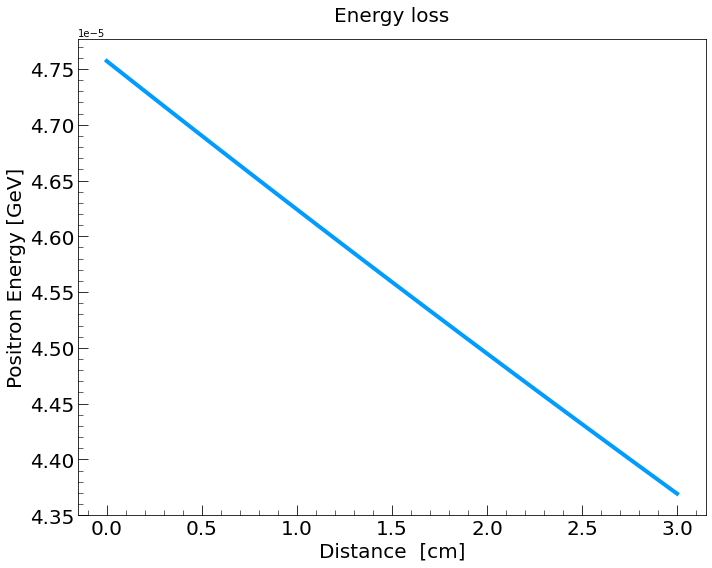

In [43]:
rad_length = 35.28  # Radiation length of Beryllium [cm]
l = 3               # Target thickness [cm]

E_0th = ( (4*mu**2-2*me**2)/(2*me) )*np.exp(l/rad_length)

print ('Threshold energy: {:.2f} MeV'.format(E_0th)) 

### Plot of energy loss in Beryllium ###

x = np.linspace(0,3,100) # distances from 0 to 3 cm 
e = E_0th * np.exp(-x/rad_length) * 1e-09

fig, ax = plt.subplots(1, figsize = (10,8))
ax.plot(x,e, lw=2, ls='-', color = '#009CFF', )

ax.set_title('Energy loss' ,fontsize = 20, pad = 18)
ax.set_xlabel('Distance  [cm]',fontsize = 20)
ax.set_ylabel('Positron Energy [GeV]',fontsize = 20)                   
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
ax.minorticks_on()

fig.tight_layout()
plt.show()


The energy loss in Beryllium is not significant as the exponential trend is not visible from the plot. Indeed along the 
3 cm target, the positrons lose in average roughly 0.4 GeV.